# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- контролировать добросовестность кассиров при продаже алкоголя.

**Задача**

Постройте модель, которая по фотографии определит приблизительный возраст человека. 

## Исследовательский анализ данных

Загружаем библиотеки.

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Загружаем и проверяем данные.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
labels.shape

(7591, 2)

In [10]:
labels.info()
print()
labels.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB



,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Построим гистограмму кол-ва человек и из возраста.

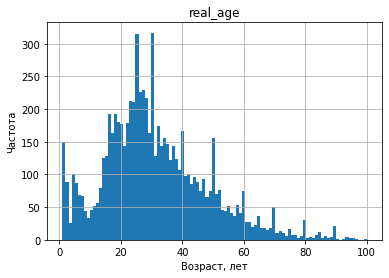

In [5]:
labels.hist(bins=100)
plt.ylabel('Частота')
plt.xlabel('Возраст, лет')
plt.show()

In [6]:
print(labels.describe())

          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000


In [7]:
features, target = next(train_gen_flow)

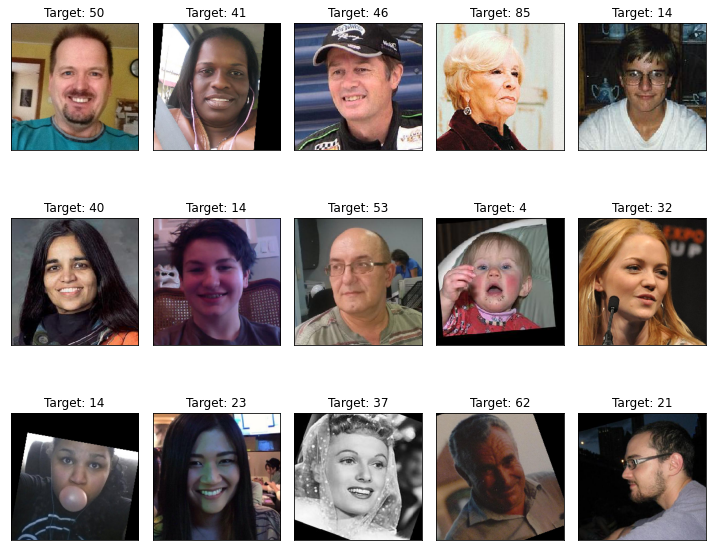

In [11]:
fig = plt.figure(figsize=(10, 10))
for i in range(15):
    fig.add_subplot(3, 5, i + 1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(f'Target: {target[i]}')  
    plt.tight_layout()

plt.show()

**Выводы по исследовательскому анализу данных:**

- Данные загружены и проверены на соответсвие 
- Средний возраст человека на фотографии из датасета - 31 год
- Большинство значений находятся в диапазоне от 20 до 40 лет
- При обучении модели некоторые фотографии могут "запутать", так как люди на фото закрывают лицо посторонними предметами, либо лицо повернуто в профиль, лицо нахожится в тени.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(weights='imagenet', 
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

Train for 356 steps, validate for 119 steps
Epoch 1/20
2025-09-06 18:57:11.675890: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-09-06 18:57:11.984885: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 50s - loss: 205.1597 - mae: 10.8922 - val_loss: 288.3336 - val_mae: 12.7720
Epoch 2/20
356/356 - 41s - loss: 137.7913 - mae: 8.9282 - val_loss: 229.3565 - val_mae: 11.8151
Epoch 3/20
356/356 - 40s - loss: 113.4279 - mae: 8.0784 - val_loss: 175.1844 - val_mae: 10.1595
Epoch 4/20
356/356 - 39s - loss: 92.4018 - mae: 7.3914 - val_loss: 113.9894 - val_mae: 8.0565
Epoch 5/20
356/356 - 39s - loss: 80.5743 - mae: 6.8287 - val_loss: 123.7637 - val_mae: 8.4374
Epoch 6/20
356/356 - 39s - loss: 68.8921 - mae: 6.3303 - val_loss: 122.5958 - val_mae: 8.8284
Epoch 7/20
356/356 - 41s - loss: 60.0819 - mae: 5.9603 - val_loss: 134.7608 - val_mae: 9.0782
Epoch 8/20
356/356 - 41s - loss: 56.1144 - mae: 5.7624 - val_loss: 104.2094 - val_mae: 7.7318
Epoch 9/20
356/356 - 42s - loss: 45.0701 - mae: 5.1707 - val_loss: 123.9835 - val_mae: 8.1320
Epoch 10/20
356/356 - 41s - loss: 35.6715 - mae: 4.5643 - val_loss: 90.7377 - val_mae: 7.1645
Epoch 11/20
356/356 - 41s - loss: 31.2937 - mae: 4.3291 - val_loss: 108.1382 - val_mae: 8.0450
Epoch 12/20
356/356 - 41s - loss: 31.5171 - mae: 4.3262 - val_loss: 91.9281 - val_mae: 7.0212
Epoch 13/20
356/356 - 41s - loss: 25.2860 - mae: 3.9265 - val_loss: 105.4678 - val_mae: 7.6107
Epoch 14/20
356/356 - 41s - loss: 22.7409 - mae: 3.6732 - val_loss: 120.3025 - val_mae: 8.2175
Epoch 15/20
356/356 - 41s - loss: 22.8320 - mae: 3.6753 - val_loss: 90.4132 - val_mae: 7.4210
Epoch 16/20
356/356 - 41s - loss: 19.4382 - mae: 3.3754 - val_loss: 100.1979 - val_mae: 7.6832
Epoch 17/20
356/356 - 41s - loss: 21.6290 - mae: 3.5516 - val_loss: 79.6945 - val_mae: 6.7190
Epoch 18/20
356/356 - 41s - loss: 19.2642 - mae: 3.3814 - val_loss: 115.4355 - val_mae: 8.0999
Epoch 19/20
356/356 - 41s - loss: 17.2854 - mae: 3.2231 - val_loss: 87.2145 - val_mae: 7.1771
Epoch 20/20
356/356 - 41s - loss: 16.6474 - mae: 3.1453 - val_loss: 93.9133 - val_mae: 7.0497
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 93.9133 - mae: 7.0497

## Анализ обученной модели

- При обучении была использована модель ResNet50 для автоматического определения возраста покупателя по фото.
- За 20 эпох обучения была получена метрика MAE, которая удовлетворяла исходному условию задачи - 7.
- Модель справляется с задачей, так как при определении возраста покупателя точная цифра не так важна, важно скорее попадание в верную возрастную категорию. 